<h1>Exercise 7</h1>

<h2>Classification Datasets</h2>
Wine Quality called D2: (use winequality-red.csv). Wine Quality Dataset
Note: Dataset D2 can also be used for a regression problem. You are required to pre-process the given datasets.

In [85]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [86]:
# Load the Wine Quality Dataset
D2 = pd.read_csv('/Users/antondoluda/Documents/AML/AML_Assignment_3/wine+quality/winequality-red.csv', sep=';')

# Separate features and target
Y_D2 = D2['quality']  # Target variable
X_D2 = D2.drop('quality', axis=1)  # Features

scaler = StandardScaler()

X_D2_normalized = pd.DataFrame(scaler.fit_transform(X_D2), columns=X_D2.columns)  # Normalize features

# Train-Test Split
Xtrain_D2, Xtest_D2, Ytrain_D2, Ytest_D2 = train_test_split(X_D2_normalized, Y_D2, test_size=0.3, random_state=42)
Xtrain_D2.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
925        0.161077         -1.719632     0.457144       -0.453218  -0.498751   
363        2.401746         -0.378878     1.843607       -0.382271  -0.349975   
906       -0.643266          0.068040    -0.005010        0.043416  -0.073677   
426       -1.102890          0.794282    -0.980669       -0.311323  -0.902572   
1251      -0.470907          0.291499    -0.672566       -0.240375  -0.222453   

      free sulfur dioxide  total sulfur dioxide   density        pH  \
925              3.550300              0.928453 -0.374550  1.029472   
363             -0.944346             -0.956903  1.088288 -2.080582   
906             -0.370562              0.958862 -0.183745  0.511130   
426              0.298854              0.046593 -0.978765  1.159057   
1251             1.063900              0.411500 -0.236746 -0.201591   

      sulphates   alcohol  
925    1.250199  0.541630  
363    1.250199 -0.209308  
906    0.305990  0.541630  
426   -0.992298  0.917099  
1251  -0.402167 -0.584777

In [87]:
# duplicate rows for minority classes to balance the dataset
def oversample(Xtrain_D2, Ytrain_D2):
    # Combine training features and labels into a single DataFrame
    train_data = pd.concat([Xtrain_D2, Ytrain_D2], axis=1)

    # Get the class distribution
    class_counts = train_data['quality'].value_counts()
    max_count = class_counts.max()

    # Oversample minority classes
    balanced_data = train_data.copy()
    for cls in class_counts.index:
        cls_data = train_data[train_data['quality'] == cls]
        oversampled_cls = cls_data.sample(max_count, replace=True, random_state=42)
        balanced_data = pd.concat([balanced_data, oversampled_cls], axis=0)

    # Shuffle the dataset
    balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

    # Separate features and labels
    Xtrain_D2_balanced = balanced_data.drop('quality', axis=1)
    Ytrain_D2_balanced = balanced_data['quality']
    return Xtrain_D2_balanced, Ytrain_D2_balanced

In [88]:
Xtrain_D2, Ytrain_D2 = oversample(Xtrain_D2, Ytrain_D2)
Xtrain_D2 = pd.DataFrame(scaler.fit_transform(Xtrain_D2), columns=Xtrain_D2.columns)
Xtest_D2 = pd.DataFrame(scaler.transform(Xtest_D2), columns=Xtest_D2.columns)

<h2>Exercise 1: Implement K-Nearest Neighbor (KNN) (4 Points)</h2>

Your task is to implement the KNN algorithm. To implement KNN, you have to:
- Split data into a train and test split (70% and 30% respectively).
- Implement a similarity (or a distance) measure. To begin with, you can implement the Euclidean Distance.
- Implement a function that returns the top K Nearest Neighbors for a given query (data point).
- Provide the prediction for a given query (for a classification task, you can use majority voting; for regression, you can use the mean).
- Measure the quality of your prediction. [Hint: Choose a quality criterion according to the task you are solving, i.e., a regression or classification task. Defend your choice].

<h3>Euclidean Distance</h3>

$
d(p, q) = \sqrt{\sum_{i=1}^{n} (p_i - q_i)^2}
$

In [89]:
def d(p,q):
    return np.sqrt(
        np.sum(
            (p-q)**2
        )
    )

In [90]:
# Top K Nearest Neighbors function for classification
def top_kkn_weighted(X_train, X_test, i, k, labels_train):
    row_i = X_test.iloc[i, :].values
    distances = np.linalg.norm(X_train.values - row_i, axis=1)
    
    # Get the indices of the top k smallest distances
    top_k_indices = np.argsort(distances)[:k]
    
    # Get the labels of the top k neighbors
    top_k_labels = labels_train.iloc[top_k_indices].values
    top_k_distances = distances[top_k_indices]
    
    # Weight the labels by the inverse of their distance
    weights = 1 / (top_k_distances + 1e-5)  # Add small value to avoid division by zero
    weighted_labels = np.zeros_like(top_k_labels, dtype=float)
    
    # Assign weights to each label
    for idx, label in enumerate(top_k_labels):
        weighted_labels[idx] = label * weights[idx]
    
    # Return the predicted label by summing the weighted labels
    return np.round(np.sum(weighted_labels) / np.sum(weights))

In [91]:
# Majority Voting function for classification
def maj_voting(neighbors):
    count = {}
    for value in neighbors:
        count[value] = count.get(value, 0) + 1
    
    # Return the most frequent label
    return max(count, key=count.get)

In [92]:
# Manually calculate accuracy
def calculate_accuracy(predictions, true_labels):
    # Flatten Y_test to ensure it is a 1D array, just like predictions
    true_labels = true_labels.values.flatten()  # Convert DataFrame to 1D array
    correct = np.sum(predictions == true_labels)
    total = len(true_labels)
    return correct / total

In [93]:
def visualize(Y_test, predictions, k):
    # Visualizing accuracy or any other metric
    plt.plot(predictions[:50], label="Predictions")
    plt.plot(Y_test.values[:50], label="True Values")
    plt.legend()
    plt.title(f"Prediction vs True Labels (First 50 Samples) - k={k}")
    plt.show()

In [94]:
# k-NN method to perform predictions and calculate accuracy
def knn_predict_and_evaluate(k, X_train, X_test, Y_train, Y_test):
    predictions = []

    # Predicting on the test set using k-NN
    for i in range(len(X_test)):
        # Get the top K neighbors' labels
        top_k_labels = top_kkn_weighted(X_train, X_test, i, k, Y_train)
        
        # Ensure that we have individual labels (no nested arrays)
        top_k_labels_flattened = top_k_labels.flatten()

        # Predict the label using majority voting
        prediction = maj_voting(top_k_labels_flattened)
        predictions.append(prediction)

    # Evaluate the quality of the predictions using manually calculated accuracy
    predictions = np.array(predictions)
    accuracy_value = calculate_accuracy(predictions, Y_test)
    
    return accuracy_value, predictions

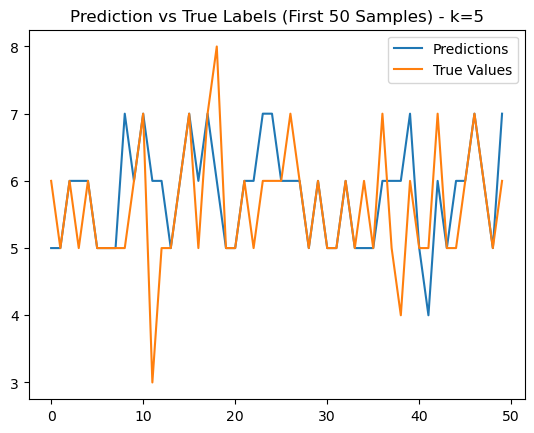

Prediction accuracy = 58.333333333333336%


In [95]:
k = 5
accuracy_value, predictions = knn_predict_and_evaluate(k, Xtrain_D2, Xtest_D2, Ytrain_D2, Ytest_D2)
visualize(Ytest_D2, predictions, k)
print(f"Prediction accuracy = {accuracy_value*100}%")

I chose Accuracy as Measure the quality of my prediction, as it is the most straightforward and commonly used metric for classification tasks.
It works well when the classes are balanced, meaning the number of instances in each class is roughly equal.
But, if there is class imbalance (e.g., many instances of one class but fewer of others), accuracy may not be the best metric, as the model could be biased towards the majority class.

<h2>Exercise 2: Optimize and Compare KNN Algorithm (6 Points)</h2>
<h3>Part A: Determine the Optimal Value of K (3 Points)</h3>
In this exercise, you need to determine the optimal value of K for the given datasets.

1. How can you choose the value of K for KNN? Provide a criterion to choose an optimal value of K.
2. Implement the criterion for choosing the optimal value of K.
3. Experimentally demonstrate that your chosen value is better than other values of K. [Hint: Run your experiment with different values of K and plot the error measure for each value].

1. I will use the 'Cross-Validation' method, that splits the data into K subsets. For each fold, it trains the k-NN model using different K values and compute the error rate. Average the errors across all folds to get a stable estimate of error. I choose it as it provides a reliable estimate of performance. The downside of the method is however that it is computationally expensive.

In [96]:
# Cross-validation and model evaluation for different K values
def find_best_k(X, Y, k_range, num_folds=5):

    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    avg_accuracies = []

    for k in k_range:
        fold_accuracies = []
        for train_index, test_index in kfold.split(X):
            X_train, X_val = X.iloc[train_index], X.iloc[test_index]
            Y_train, Y_val = Y.iloc[train_index], Y.iloc[test_index]

            # Predict and calculate accuracy
            _, predictions = knn_predict_and_evaluate(k, X_train, X_val, Y_train, Y_val)
            fold_accuracy = calculate_accuracy(predictions, Y_val)
            fold_accuracies.append(fold_accuracy)

        # Compute the mean accuracy for this k
        avg_accuracies.append(np.mean(fold_accuracies))

    # Find the best k
    best_k = k_range[np.argmax(avg_accuracies)]
    return best_k, avg_accuracies

In [97]:
# List of K values to test
k_values = range(1, 21)

# Call the function to evaluate and plot performance for each K
best_k, accuracies = find_best_k(Xtrain_D2, Ytrain_D2, k_values)
print(f"The best k = {best_k}.")

The best k = 2.


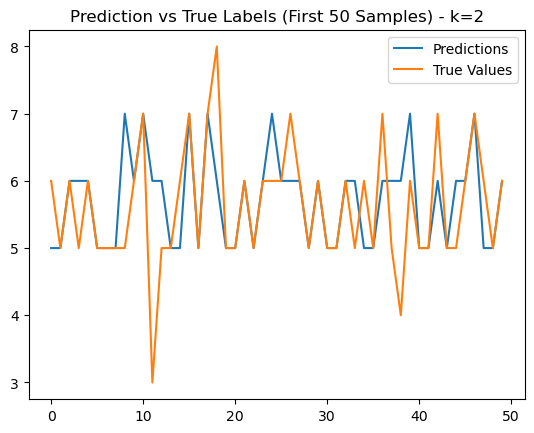

Prediction accuracy = 62.5%


In [98]:
accuracy_value, predictions = knn_predict_and_evaluate(best_k, Xtrain_D2, Xtest_D2, Ytrain_D2, Ytest_D2)
visualize(Ytest_D2, predictions, best_k)
print(f"Prediction accuracy = {accuracy_value*100}%")

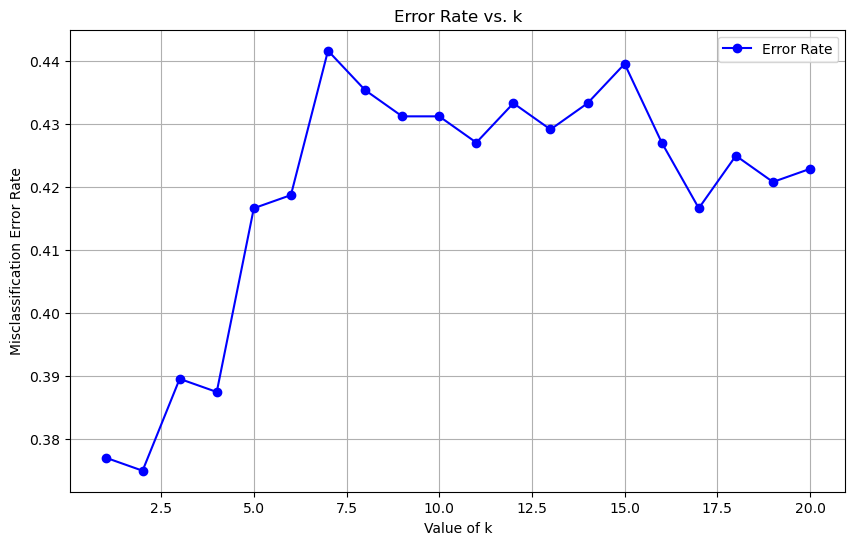

In [99]:
def knn_error_rate_plot(X_train, X_test, Y_train, Y_test, k_values):
    error_rates = []  # To store error rates for each k
    
    for k in k_values:
        
        # Predict using k-NN
        _, predictions = knn_predict_and_evaluate(k, X_train, X_test, Y_train, Y_test)
        
        # Calculate error rate
        error_rate = 1 - calculate_accuracy(predictions, Y_test)
        error_rates.append(error_rate)
    
    # Plot Error Rate vs k
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, error_rates, marker='o', linestyle='-', color='b', label='Error Rate')
    plt.xlabel('Value of k')
    plt.ylabel('Misclassification Error Rate')
    plt.title('Error Rate vs. k')
    plt.legend()
    plt.grid()
    plt.show()
    
    return error_rates

# Range of k values to test
k_values = range(1, 21)

# Call the function
error_rates = knn_error_rate_plot(Xtrain_D2, Xtest_D2, Ytrain_D2, Ytest_D2, k_values)

<h2>Part B: Compare KNN Algorithm with Tree-Based Methods (3 Points)</h2>
In this task, you are allowed to use Scikit-Learn. In particular, you will use the Nearest Neighbor and Decision Tree implementations provided by Scikit-Learn.

- Use Nearest Neighbor and Decision Tree provided by Scikit-Learn to solve the classification task for the two datasets.
- Provide the optimal hyperparameters for both methods. [Hint: Use Grid Search and cross-validation and present results to support your solution].
- Present a comparison of the two methods using evaluation results on test datasets. [Hint: It is better to use cross-validation to confirm your results].

In [100]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

In [101]:
# The k-NN model
knn = KNeighborsClassifier()

# Define the hyperparameter grid
param_grid_knn = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Use Grid Search with 5-fold cross-validation
grid_knn = GridSearchCV(knn, param_grid_knn, cv = 5, scoring='accuracy', verbose=1)
grid_knn.fit(Xtrain_D2, Ytrain_D2)

# Best parameters and score for k-NN
print(f"Best k-NN Parameters: {grid_knn.best_params_}")
print(f"Best k-NN Accuracy (CV): {grid_knn.best_score_:.4f}")

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best k-NN Parameters: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Best k-NN Accuracy (CV): 0.9591


In [102]:
# Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Hyperparameters
param_grid_dt = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6]
}

# Grid Search with 5-fold cross-validation
grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy', verbose=1)
grid_dt.fit(Xtrain_D2, Ytrain_D2)

# Best parameters and score for Decision Tree
print(f"Best Decision Tree Parameters: {grid_dt.best_params_}")
print(f"Best Decision Tree Accuracy (CV): {grid_dt.best_score_:.4f}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Decision Tree Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Decision Tree Accuracy (CV): 0.9554


In [103]:
# Evaluate k-NN on Test Data
knn_best = grid_knn.best_estimator_
knn_predictions = knn_best.predict(Xtest_D2)
knn_accuracy = accuracy_score(Ytest_D2, knn_predictions)
print(f"k-NN Test Accuracy: {knn_accuracy:.4f}")
print("k-NN Classification Report:")
print(classification_report(Ytest_D2, knn_predictions))

# Evaluate Decision Tree on Test Data
dt_best = grid_dt.best_estimator_
dt_predictions = dt_best.predict(Xtest_D2)
dt_accuracy = accuracy_score(Ytest_D2, dt_predictions)
print(f"Decision Tree Test Accuracy: {dt_accuracy:.4f}")
print("Decision Tree Classification Report:")
print(classification_report(Ytest_D2, dt_predictions))

k-NN Test Accuracy: 0.6208
k-NN Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.12      0.12      0.12        17
           5       0.74      0.68      0.71       195
           6       0.61      0.64      0.62       200
           7       0.53      0.59      0.56        61
           8       0.12      0.17      0.14         6

    accuracy                           0.62       480
   macro avg       0.35      0.36      0.36       480
weighted avg       0.63      0.62      0.62       480

Decision Tree Test Accuracy: 0.6021
Decision Tree Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.07      0.06      0.06        17
           5       0.68      0.66      0.67       195
           6       0.62      0.61      0.62       200
           7       0.51      0.57      0.54        61
    

In [104]:
# Cross-validation scores for k-NN
cv_scores_knn = cross_val_score(knn_best, Xtrain_D2, Ytrain_D2, cv=5, scoring='accuracy')
print(f"k-NN Cross-Validation Accuracy: {np.mean(cv_scores_knn):.4f} ± {np.std(cv_scores_knn):.4f}")

# Cross-validation scores for Decision Tree
cv_scores_dt = cross_val_score(dt_best, Xtrain_D2, Ytrain_D2, cv=5, scoring='accuracy')
print(f"Decision Tree Cross-Validation Accuracy: {np.mean(cv_scores_dt):.4f} ± {np.std(cv_scores_dt):.4f}")

k-NN Cross-Validation Accuracy: 0.9591 ± 0.0034
Decision Tree Cross-Validation Accuracy: 0.9554 ± 0.0038


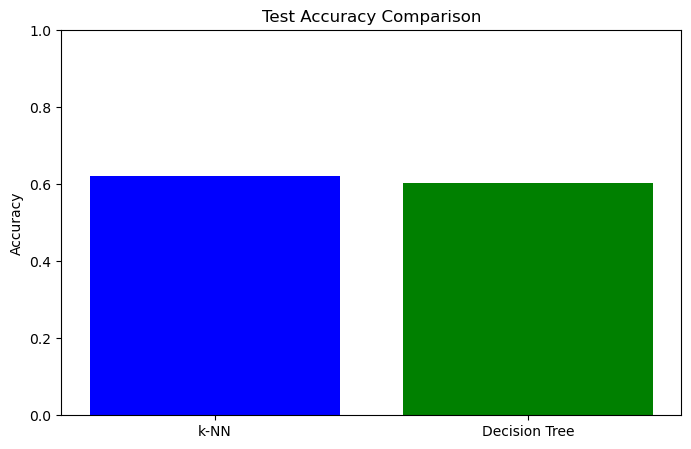

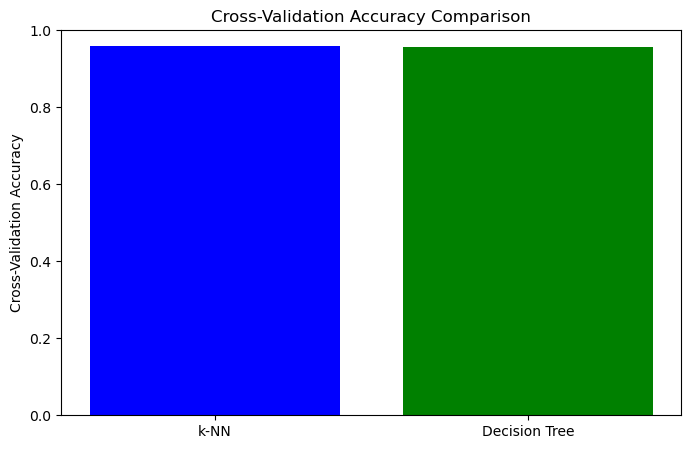

In [105]:
# Compare Test Accuracy
methods = ['k-NN', 'Decision Tree']
test_accuracies = [knn_accuracy, dt_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(methods, test_accuracies, color=['blue', 'green'])
plt.ylabel('Accuracy')
plt.title('Test Accuracy Comparison')
plt.ylim(0, 1)
plt.show()

# Compare Cross-Validation Results
cv_accuracies = [np.mean(cv_scores_knn), np.mean(cv_scores_dt)]

plt.figure(figsize=(8, 5))
plt.bar(methods, cv_accuracies, color=['blue', 'green'])
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Accuracy Comparison')
plt.ylim(0, 1)
plt.show()